In [1]:
import pandas as pd
import numpy as np
import openai
import re
import os
import glob
import json
import seaborn as sns
import matplotlib.pyplot as plt
from loading_helpers import *

In [ ]:
openai.api_key=os.environ['OPENAI_API_KEY']
client = OpenAI()


In [3]:
df=pd.read_json('filtered_corpus.jsonl', lines=True)
df=df[df['file_name']=='Divan_Prak10']
df.to_json('Divan_Prak10.jsonl', lines=True, orient='records')


In [6]:
reference_terms=pd.read_excel('C:/Users/Kamal/OneDrive/Desktop/PDS/Copy of corpus_inscription_terms.xlsx',sheet_name='Terms with Examples')
reference_terms.dropna(subset=['term'],inplace=True) 
reference_terms.drop_duplicates(subset=['term','example'],inplace=True)
reference_terms['term']=reference_terms['term'].apply(lambda x: clean_text(x))
reference_terms

,term,file,count_in_file,example
0,տապանագիր,Divan_Prak10.txt,2,"նք, գերեզմանոց - Լմբատավանք, գերեզմանոց տապան..."
2,սեպագիր,Divan_Prak4.txt,1,"ն րերդշեն, որը գրավել է ուրարտական Ռուսա թագավ..."
3,ալս գլուղում պահպանվել են արձանագրություն,Divan_Prak3.txt,1,ԵՒ ՈՎՍԵՓԱ. ԹՎ. 2։ (1251) Ծանոթ. Գծագիրն ստացե...
4,ալս մատուռի մեջ անցլալում եղել են չորս ձեռագիր,Divan_Prak5.txt,1,"զրին. փոք- րիկ մատուռ է, որի բեմի տակ դամբարան..."
5,ամփոփ տեղեկագիր,ՀԱԼԵՊԻ-ԱՐՁԱՆԱԳՐՈՒԹՅՈՒՆՆԵՐԸ.txt,2,"., նշվ. աշխ., էջ 310։ 113 Գապպէնճեան Գ., նշվ...."
...,...,...,...,...
690,քարերն անարձանագիր,Բուն-Աղվանք-1.txt,1,"5, ծ. մ. 759 #)։ Բնիկ հայերից ավանդված ուղղակյ..."
691,քարտեզագիր,Խոջիվանք.txt,1,"թ. Բագարով Սիրան, վխճ. 1926 թ. 167 Բագրատիոն..."
692,օգտվել է յոհան ոսկերչյան քահանայի ծեռագիր,Divan_Prak9.txt,1,իր պատ- վանդանին։ Սեջտեղի կոտրված մասի մեկ տող...
693,օրագիր,Divan_Prak10.txt,1,րսի» 3. եղիազարյան - «զիս զինչ թը սմայ ունէի տ...


In [7]:
unique_terms=pd.read_excel('C:/Users/Kamal/OneDrive/Desktop/PDS/Copy of corpus_inscription_terms.xlsx',sheet_name='Unique Terms')
unique_terms.drop(columns=['Unnamed: 2'],inplace=True)
unique_terms.dropna(inplace=True)
unique_terms

,term,total_count
0,հիշատակագրություն,83
1,արձանագիր,35
2,հիշատակագիր,30
3,արձանագրություն,26
4,ձեռագիր,26
...,...,...
552,խնդրագիր,1
555,վայելչագիր,1
556,բառ պատուագիր,1
567,ապագիր,1


In [8]:
one_gram_terms=reference_terms[reference_terms['term'].apply(lambda x: len(x.split()) ==1)]
one_gram_terms=one_gram_terms.groupby('term').agg(list)
one_gram_terms

,file,count_in_file,example
term,,,
աեղագիր,[Divan_Prak4.txt],[1],[ՅՈԱՂՐԱՆ (ՀՆՈՒՍ՝ ՓԱՌԱԿԱՆՔ) Այո գյաղի անունը մ...
ազգագրություն,[ԱՐՑԱԽԻ-ԵՎ-ՍՅՈՒՆԻՔԻ-ՄԵԼԻՔԱԿԱՆ-ԱՊԱՐԱՆՔՆԵՐԸ.txt],[2],[յանների համահայկական իշխանա- Տե՛ս Ստ. Լիսիցյ...
ամսագիր,"[Divan_Prak7.txt, Բուն-Աղվանք-1.txt]","[1, 4]","[րում է Նախիջևան Բեսարարիայի հայոց թեմը. մտրգ,..."
անարձանագիր,"[Divan_Prak3.txt, Divan_Prak4.txt, Divan_Prak5...","[1, 2, 2, 5]",[կրորդ եկեղեցին կից է ո. Հովհանեսին հլուսիսից....
անստորագիր,[ՀԱԼԵՊԻ-ԱՐՁԱՆԱԳՐՈՒԹՅՈՒՆՆԵՐԸ.txt],[1],"[նքի մատնուիլ..., ըսաւ ինծի ոստիկան մը.... սպա..."
...,...,...,...
փորագիր,"[Divan_Prak4.txt, Divan_Prak9.txt, ՀԱԼԵՊԻ-ԱՐՁԱ...","[1, 6, 1, 2]",[երս նայող թեք շրջանակներին մեկ տող ուռուցիկ և...
քարտեզագիր,[Խոջիվանք.txt],[1],"[թ. Բագարով Սիրան, վխճ. 1926 թ. 167 Բագրատիո..."
օրագիր,[Divan_Prak10.txt],[1],[րսի» 3. եղիազարյան - «զիս զինչ թը սմայ ունէի ...


### Defining new dataframe for type of inscription

In [9]:
types_of_inscriptions=pd.read_csv('C:/Users/Kamal/OneDrive/Desktop/PDS/types_of_inscriptions.csv')
types_of_inscriptions.head()

,Term,Definition
0,Վիմագիր,Ընդհանուր տերմին բոլոր քարե արձանագրություններ...
1,վիմական արձանագրություն,Ընդհանուր տերմին բոլոր քարե արձանագրություններ...
2,Տապանագիր,Գերեզմանային արձանագրություն (գերեզմանոցներում...
3,տապանաքարային արձանագրություն,Գերեզմանային արձանագրություն (գերեզմանոցներում...
4,տապանաքարային վիմագիր,Գերեզմանային արձանագրություն (գերեզմանոցներում...


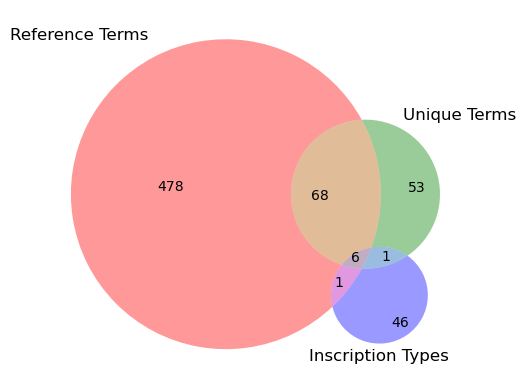

In [10]:
from matplotlib_venn import venn3
set_ref=set(reference_terms['term'])
set_unique=set(unique_terms['term'])
set_inscriptions=set(types_of_inscriptions['Term'].apply(lambda x: clean_text(x)))
venn3([set_ref, set_unique,set_inscriptions], set_labels=("Reference Terms", "Unique Terms","Inscription Types"))

## Strategy
Start out with the inscribtion since definition recorded, then move on to different sets if needed.

## Pydantic Scheme

First directed output method lies in directing the model to find occurences of a certain term in chunks of the text.

In [11]:
from pydantic import BaseModel,Field
from typing import Optional,List


class Occurence(BaseModel):
    file_name: str = Field(None, description="Name of the file where the term was found")
    page_number: int= Field(None, description="Number of the page where the term was found")
    term: str= Field(None, description="Term found in the document")
    context: str= Field(None, description="Context around the term found in the document")

class Term(BaseModel):
    term: str = Field(None, description="The term to be extracted")
    definition: str = Field(None, description="The definition of the term")
    extractions: Optional[List[Occurence]] = Field(default_factory=list, description="List of extractions")


class ExtractionResult(BaseModel):
    terms: List[Term]


terms_list = types_of_inscriptions.to_dict(orient="records")


In [12]:
from openai import OpenAI
client = OpenAI()


## Prompt Engineering

For now zero, one ,few shot. Then test out CoT prompting,

### Chunking tool

In [13]:
def chunk_jsonl_for_model(file_path: str, max_chars: int = 5000):
    """
    Reads a JSONL file with keys (file_name, page_number, cleaned_text)
    and yields chunks of formatted text under max_chars length.

    Args:
        file_path (str): Path to the JSONL file
        max_chars (int): Maximum number of characters per chunk

    Yields:
        str: Chunk of text ready to send to the model
    """
    buffer = ""
    
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            record = json.loads(line)
            formatted = (
                f"--- File_name: {record['file_name']} , Page_number: {record['page_number']} ---\n"
                f"{record['cleaned_text']}\n\n"
            )
            
            # If adding this line would exceed max_chars, yield buffer and reset
            if len(buffer) + len(formatted) > max_chars and buffer:
                yield buffer.strip()
                buffer = ""
            
            buffer += formatted
        
        # Yield remaining buffer if not empty
        if buffer.strip():
            yield buffer.strip()

In [14]:
from typing import Generator
import tiktoken

def chunk_jsonl_for_openai(file_path: str, max_tokens: int = 2000, model: str = "gpt-4"):
    """
    Reads a JSONL file and yields chunks formatted for OpenAI API.
    Each chunk is under max_tokens for the given model.
    
    Args:
        file_path (str): path to JSONL file
        max_tokens (int): max tokens per chunk
        model (str): OpenAI model name for token encoding
        
    Yields:
        str: chunk of text ready for model input
    """
    # Initialize tokenizer
    enc = tiktoken.get_encoding("cl100k_base")
    buffer = ""
    buffer_tokens = 0
    
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            record = json.loads(line)
            formatted = (
                f"--- File_name: {record['file_name']} , Page_number: {record['page_number']} ---\n"
                f"{record['cleaned_text']}\n\n"
            )
            line_tokens = len(enc.encode(formatted))
            
            # If adding this line exceeds max_tokens, yield buffer and reset
            if buffer_tokens + line_tokens > max_tokens and buffer:
                yield buffer.strip()
                buffer = ""
                buffer_tokens = 0
            
            buffer += formatted
            buffer_tokens += line_tokens
        
        if buffer.strip():
            yield buffer.strip()


In [15]:
def zero_shot_prompting(chunk,terms):

    zero_shot_prompt=f"""You are an expert in armenian epigraphy. 
    Your task is to extract specific terms from the provided text chunks. 
    For each term, you will identify its occurrences in the text, along with the context in which it appears. 
    The context should include a few words before and after the term to provide clarity on its usage.

    Each occurrence should be documented with the following details:
    - file_name: The name of the file where the term was found.
    - page_number: The page number in the document where the term was found.
    - term: The term itself.
    - context: A snippet of text surrounding the term to provide context.

    Each term can have multiple occurrences, and each occurrence should be recorded separately and stored in an Occurence object.
    All occurrences of a term should be grouped under a Term object, which includes the term, its definition, and a list of its occurrences.

    Finally, all Term objects should be compiled into an ExtractionResult object.

    The text is written in armenian which might be more tedious to handle than engilsh text.
    Extract all occurrences of the following terms from the document text.
    Terms and definitions: {terms}
    
    --- BEGIN TEXT CHUNK ---
    {chunk}
    --- END TEXT CHUNK ---
    """

    return zero_shot_prompt

In [ ]:
from pathlib import Path
from tqdm import tqdm
def extract_terms_and_save(jsonl_file: str, output_dir: str, terms_list: list, max_tokens: int = 20000, model: str = "gpt-5"):
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    chunks = chunk_jsonl_for_openai(jsonl_file, max_tokens=max_tokens, model=model)
    
    for i, chunk in tqdm(enumerate(chunks)):
        print(f"Processing chunk {i+1}")
        
        response = client.beta.chat.completions.parse(
            model=model,
            messages=[
                {"role": "system", "content": "You are an assistant that extracts Armenian epigraphic terms."},
                {"role": "user", "content": f"""
                {zero_shot_prompting(chunk, terms_list)}
                """}
            ],
            response_format=ExtractionResult
        ).choices[0].message.parsed
        print(type(response)) 
        terms_only = {"terms": [term.model_dump() for term in response.terms]}  # convert Pydantic objects to dict

        out_file = Path(output_dir) / f"extraction_chunk_{i+1}.json"
        with open(out_file, "w", encoding="utf-8") as f:
            import json
            json.dump(terms_only, f, ensure_ascii=False, indent=2)

        


In [18]:
extract_terms_and_save("Divan_Prak10.jsonl","divan10",terms_list=terms_list)

0it [00:00, ?it/s]

Processing chunk 1


1it [01:54, 114.96s/it]

<class '__main__.ExtractionResult'>
Processing chunk 2


2it [04:08, 125.64s/it]

<class '__main__.ExtractionResult'>
Processing chunk 3


3it [05:29, 105.34s/it]

<class '__main__.ExtractionResult'>
Processing chunk 4


4it [07:03, 101.02s/it]

<class '__main__.ExtractionResult'>
Processing chunk 5


5it [10:00, 128.25s/it]

<class '__main__.ExtractionResult'>
Processing chunk 6


6it [12:06, 127.45s/it]

<class '__main__.ExtractionResult'>
Processing chunk 7


7it [15:27, 151.48s/it]

<class '__main__.ExtractionResult'>
Processing chunk 8


8it [17:05, 134.70s/it]

<class '__main__.ExtractionResult'>
Processing chunk 9


9it [18:58, 127.90s/it]

<class '__main__.ExtractionResult'>
Processing chunk 10


10it [21:15, 130.55s/it]

<class '__main__.ExtractionResult'>
Processing chunk 11


11it [23:25, 130.39s/it]

<class '__main__.ExtractionResult'>
Processing chunk 12


12it [24:50, 116.61s/it]

<class '__main__.ExtractionResult'>
Processing chunk 13


13it [27:30, 129.68s/it]

<class '__main__.ExtractionResult'>
Processing chunk 14


14it [30:40, 148.13s/it]

<class '__main__.ExtractionResult'>
Processing chunk 15


15it [33:06, 147.28s/it]

<class '__main__.ExtractionResult'>
Processing chunk 16


16it [35:23, 144.28s/it]

<class '__main__.ExtractionResult'>
Processing chunk 17


17it [37:26, 137.94s/it]

<class '__main__.ExtractionResult'>
Processing chunk 18


18it [39:49, 139.46s/it]

<class '__main__.ExtractionResult'>
Processing chunk 19


19it [42:34, 146.96s/it]

<class '__main__.ExtractionResult'>
Processing chunk 20


20it [44:52, 144.33s/it]

<class '__main__.ExtractionResult'>
Processing chunk 21


21it [47:51, 154.72s/it]

<class '__main__.ExtractionResult'>
Processing chunk 22


22it [49:33, 135.14s/it]

<class '__main__.ExtractionResult'>
